1.downloading necessary libraries

In [3]:
! pip install requests pandas numpy matplotlib scikit-learn xgboost tensorflow joblib 


  Using cached pandas-2.3.3-cp310-cp310-win_amd64.whl.metadata (19 kB)
  Using cached matplotlib-3.10.7-cp310-cp310-win_amd64.whl.metadata (11 kB)
  Using cached scikit_learn-1.7.2-cp310-cp310-win_amd64.whl.metadata (11 kB)
  Using cached xgboost-3.1.1-py3-none-win_amd64.whl.metadata (2.1 kB)
  Using cached tensorflow-2.20.0-cp310-cp310-win_amd64.whl.metadata (4.6 kB)
  Using cached joblib-1.5.2-py3-none-any.whl.metadata (5.6 kB)
  Using cached contourpy-1.3.2-cp310-cp310-win_amd64.whl.metadata (5.5 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached fonttools-4.60.1-cp310-cp310-win_amd64.whl.metadata (114 kB)
  Using cached kiwisolver-1.4.9-cp310-cp310-win_amd64.whl.metadata (6.4 kB)
  Using cached pyparsing-3.2.5-py3-none-any.whl.metadata (5.0 kB)
Using cached pandas-2.3.3-cp310-cp310-win_amd64.whl (11.3 MB)
Using cached matplotlib-3.10.7-cp310-cp310-win_amd64.whl (8.1 MB)
Using cached scikit_learn-1.7.2-cp310-cp310-win_amd64.whl (8.9 MB)
Using cached x

ERROR: Could not install packages due to an OSError: [WinError 32] The process cannot access the file because it is being used by another process: 'C:\\Users\\User\\.conda\\envs\\tf\\Lib\\site-packages\\pandas\\tests\\frame\\test_stack_unstack.py'
Consider using the `--user` option or check the permissions.



2.import librarries

In [21]:
! pip install --upgrade scikit-learn


In [19]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from xgboost import XGBRegressor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import joblib
from datetime import datetime, timedelta


3.Fetch Historical Forex Data via API

In [13]:
def get_forex_data(base='EUR', target='USD', api_key='RULHTPRZMKMFZ507'):
    url = f'https://www.alphavantage.co/query?function=FX_DAILY&from_symbol={base}&to_symbol={target}&apikey={api_key}&outputsize=compact'
    response = requests.get(url)

    if response.status_code != 200:
        raise Exception(f"HTTP Error: {response.status_code}")

    data = response.json()
    if "Time Series FX (Daily)" not in data:
        print("Error response:", data)
        raise Exception("Invalid API response or API limit reached.")

    fx_data = data["Time Series FX (Daily)"]

    df = pd.DataFrame([
        {"Date": date, "Close": float(fx_data[date]["4. close"])}
        for date in fx_data
    ])

    df["Date"] = pd.to_datetime(df["Date"])
    df.sort_values("Date", inplace=True)
    df.set_index("Date", inplace=True)

    # Filter data for last 2 months
    cutoff_date = datetime.now() - timedelta(days=60)
    df = df[df.index >= cutoff_date]

    return df

# Run and view the result
df = get_forex_data('EUR', 'USD')
print(df.head())
print(f"\nData points: {len(df)}")

             Close
Date              
2025-09-02  1.1638
2025-09-03  1.1661
2025-09-04  1.1649
2025-09-05  1.1717
2025-09-08  1.1762

Data points: 43


4.Feature Engineering

In [14]:
df['Return'] = df['Close'].pct_change()
df['MA_5'] = df['Close'].rolling(5).mean()
df['MA_10'] = df['Close'].rolling(10).mean()
df = df.dropna()

X = df[['MA_5', 'MA_10', 'Return']]
y = df['Close']

split = int(0.8 * len(df))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

5.XGBoost Model

In [23]:
model_xgb = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
model_xgb.fit(X_train, y_train)

preds_xgb = model_xgb.predict(X_test)
rmse_xgb = np.sqrt(mean_squared_error(y_test, preds_xgb))
print("XGBoost RMSE:", rmse_xgb)

XGBoost RMSE: 0.004533770951232891


6.Plot XGBoost Results

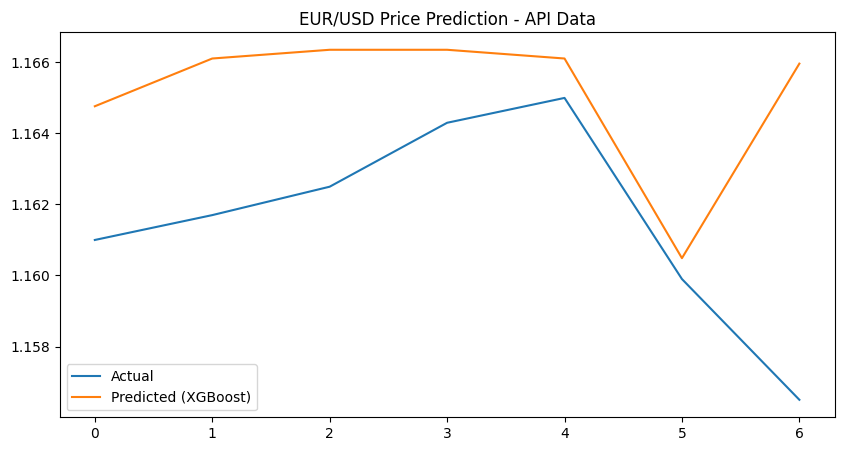

In [24]:
plt.figure(figsize=(10,5))
plt.plot(y_test.values, label='Actual')
plt.plot(preds_xgb, label='Predicted (XGBoost)')
plt.title('EUR/USD Price Prediction - API Data')
plt.legend()
plt.show()

7.LSTM Model

In [27]:
n_steps = 10
X_lstm, y_lstm = [], []

for i in range(n_steps, len(scaled_close)):
    X_lstm.append(scaled_close[i - n_steps:i, 0])
    y_lstm.append(scaled_close[i, 0])

X_lstm, y_lstm = np.array(X_lstm), np.array(y_lstm)

# Check if data exists before reshaping
if X_lstm.size == 0:
    raise ValueError("LSTM input is empty. Reduce n_steps or ensure enough data points.")

X_lstm = X_lstm.reshape(X_lstm.shape[0], X_lstm.shape[1], 1)

split_lstm = int(0.8 * len(X_lstm))
X_train_lstm, X_test_lstm = X_lstm[:split_lstm], X_lstm[split_lstm:]
y_train_lstm, y_test_lstm = y_lstm[:split_lstm], y_lstm[split_lstm:]


8.Train LSTM

In [28]:
model_lstm = Sequential([
    LSTM(50, return_sequences=True, input_shape=(X_train_lstm.shape[1], 1)),
    LSTM(50),
    Dense(1)
])

model_lstm.compile(optimizer='adam', loss='mse')
model_lstm.fit(X_train_lstm, y_train_lstm, epochs=5, batch_size=32, verbose=1)

c:\Users\User\.conda\envs\tf\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step - loss: 0.1449
Epoch 2/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step - loss: 0.1131
Epoch 3/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 0.0861
Epoch 4/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 506ms/step - loss: 0.0638
Epoch 5/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - loss: 0.0459


9.Evaluate LSTM

In [30]:
preds_lstm = model_lstm.predict(X_test_lstm)
preds_lstm_rescaled = scaler.inverse_transform(preds_lstm)
y_test_lstm_rescaled = scaler.inverse_transform(y_test_lstm.reshape(-1, 1))

rmse_lstm = np.sqrt(mean_squared_error(y_test_lstm_rescaled, preds_lstm_rescaled))
print("LSTM RMSE:", rmse_lstm)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step
LSTM RMSE: 0.003287672699484168


10.Compare Models

In [31]:
print("XGBoost RMSE:", rmse_xgb)
print("LSTM RMSE:", rmse_lstm)

if rmse_xgb < rmse_lstm:
    print("XGBoost performed better.")
else:
    print("LSTM performed better.")

XGBoost RMSE: 0.004533770951232891
LSTM RMSE: 0.003287672699484168
LSTM performed better.


11.Save the Better Model

In [32]:
if rmse_xgb < rmse_lstm:
    joblib.dump(model_xgb, 'model_eurusd_xgb.pkl')
    print("Saved XGBoost model.")
else:
    model_lstm.save('model_eurusd_lstm.h5')
    print("Saved LSTM model.")

Saved LSTM model.


12.actual vs predicted forex prices

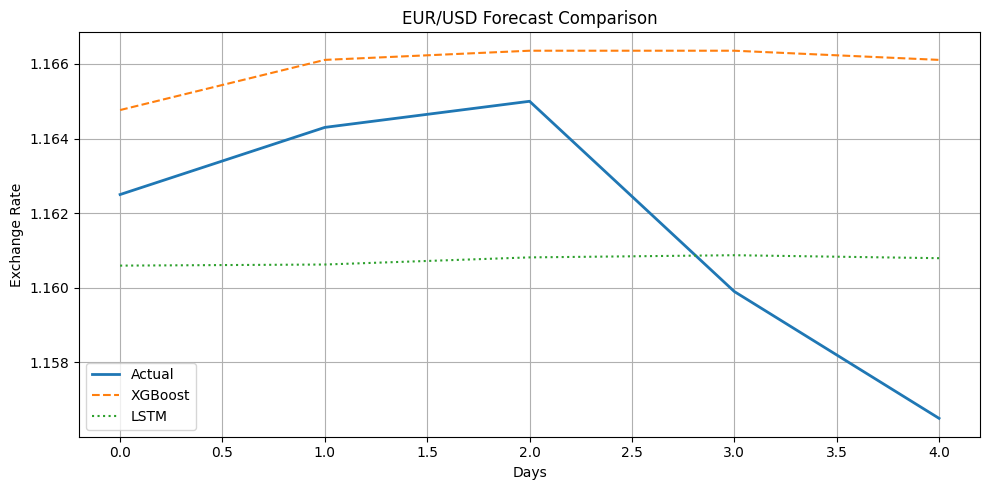

In [33]:
# Align predictions and actual values
x_axis = np.arange(len(y_test_lstm_rescaled))

plt.figure(figsize=(10,5))
plt.plot(x_axis, y_test_lstm_rescaled, label='Actual', linewidth=2)
plt.plot(x_axis, preds_xgb[:len(y_test_lstm_rescaled)], label='XGBoost', linestyle='--')
plt.plot(x_axis, preds_lstm_rescaled, label='LSTM', linestyle=':')
plt.title('EUR/USD Forecast Comparison')
plt.xlabel('Days')
plt.ylabel('Exchange Rate')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()